# Total Number of Iterations

## Setup and loading datasets

In [105]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from tqdm import tqdm
from openTSNE import TSNE

# for local imports  
from pathlib import Path
import sys
import os 

script_dir = Path.cwd().parent / "scripts"
sys.path.append(str(script_dir))

figures_dir = Path.cwd().parent / "figures"
sys.path.append(str(figures_dir))

results_dir = Path.cwd().parent / "results"
sys.path.append(str(results_dir))

import datasets
import quality_measures
import styles

In [106]:
def load_all_datasets(): 
    """This function loads: Iris, Mouse Retina, MNIST and flow18 datasets"""
    all_datasets = [None] * 4

    all_datasets[0] = datasets.load_iris_data()
    all_datasets[1] = datasets.load_mouse_retina()
    all_datasets[2] = datasets.load_mnist()
    all_datasets[3] = datasets.load_flow18()

    return all_datasets

In [107]:
all_data = load_all_datasets()

/Users/soli/Desktop/uni/thesis/code/scripts/datasets.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["class"] = df_filtered["class"].map(class_mapping)


## Functions for Running and Plotting

### KLD Monitoring

In [108]:
from openTSNE import callbacks

class KLDMonitor(callbacks.Callback):
    def __init__(self, record_every=5):
        self.record_every = record_every
        self.kl_divergences = {}
    
    def __call__(self, iteration, error, embedding):
        """
        Monitors KL divergence while ensuring unique iteration values.
        """
        # Only check every `record_every` iterations
        if iteration % self.record_every == 0:
            # in this case we are in the embedding phase  
            if iteration in self.kl_divergences or iteration > 250:
                self.kl_divergences[iteration + 250] = error 
            # in the EE phase     
            else: 
                self.kl_divergences[iteration] = error


### Running t-SNE (returns embedding dict)

In [109]:
def run_tsne_with_callbacks(datasets, iteration_lengths, verbose=False): 
    """Returns embedding dictionary with keys given by iteration length and dataset used to generate the embedding."""
  
    embedding_dict = {}
    for T in tqdm(iteration_lengths): 
        for i, dataset in enumerate(datasets): 
            data, labels = dataset
            # convert to np array (from dataframe) 
            if hasattr(data, "values"):
                data = data.values.astype(np.float64)
                
            kld_monitor = KLDMonitor()
            tsne = TSNE(early_exaggeration_iter=int(T/4), n_iter=T, n_jobs=-1, callbacks=kld_monitor, callbacks_every_iters=5, random_state=42, verbose=verbose)
            embedding = tsne.fit(data)
            kld_values = kld_monitor.kl_divergences
            embedding_dict[(T, i)] = (embedding, labels, kld_values)
    
    return embedding_dict 

In [110]:
import time
import json

def run_tsne_with_callbacks_and_timing(datasets, iteration_lengths, verbose=False, filename="n_iter_times.json"):
    """Returns embedding dictionary with keys given by iteration length and dataset used to generate the embedding.
    
    Also tracks and saves the time taken for each embedding run to a JSON file.
    
    Parameters:
    - datasets: list of tuples (data, labels)
    - iteration_lengths: list of iteration counts for t-SNE (e.g., [250, 500, 1000])
    - verbose (bool): If True, prints additional TSNE information.
    - save_times_path (str): File path to automatically save the time tracking data.
    
    Returns:
    - embedding_dict: dictionary with keys (T, dataset_index) mapping to (embedding, labels, kld_values)
    """
    embedding_dict = {}
    timings = []  # List to store timing information for each embedding

    save_times_path = os.path.join(results_dir, filename)

    for T in tqdm(iteration_lengths):
        for i, dataset in enumerate(datasets):
            data, labels = dataset
            # Convert to np.array if data is a DataFrame
            if hasattr(data, "values"):
                data = data.values.astype(float)
            
            kld_monitor = KLDMonitor()
            tsne = TSNE(early_exaggeration_iter=int(T/4), n_iter=T, n_jobs=-1,
                        callbacks=kld_monitor, callbacks_every_iters=5,
                        random_state=42, verbose=verbose)
            
            start_time = time.time()
            embedding = tsne.fit(data)
            elapsed_time = time.time() - start_time
            
            kld_values = kld_monitor.kl_divergences
            embedding_dict[(T, i)] = (embedding, labels, kld_values)
            
            # Record timing data for this embedding
            timings.append({
                "iterations": T,
                "dataset_index": i,
                "time_taken_seconds": elapsed_time
            })

    # Automatically save the timing information to the specified JSON file.
    with open(save_times_path, "w") as f:
        json.dump(timings, f, indent=4)
    
    return embedding_dict


### Plotting Grid

In [ ]:
# import distinctipy

In [ ]:
#colors = distinctipy.get_colors(12, pastel_factor=0.2)
# from matplotlib.colors import ListedColormap
# Create a custom colormap
# distinctipy = ListedColormap(colors)

In [ ]:
def plot_embedding_grid(embeddings, row_parameter, column_parameter, row_string="", column_string="", cmap="tab20"):
    """
    Plots a grid of t-SNE embeddings with a common column label.

    Parameters:
    - embeddings (dict): Keys are (col_value, row_value) tuples, and values are (embedding_array, labels, kld_values).
    - row_parameter (list): Values for rows (e.g., datasets [0, 1, 2, 3]).
    - column_parameter (list): Values for columns (e.g., number of iterations, perplexity, etc.).
    - row_string (str): Label for the row axis.
    - column_string (str): Common label for the column axis (displayed once over the grid).
    - cmap: "tab20" by default 
    """
    num_rows = len(row_parameter)
    num_cols = len(column_parameter)
    
    #subplot_size = 3  
    fig, axes = plt.subplots(num_rows, num_cols, 
                             figsize=(12, 10), # (num_cols * subplot_size, num_rows * subplot_size), 
                             squeeze=False)
    
    # Add a common column label above the grid 
    fig.suptitle(column_string, fontsize=12)

    # cmap 
    #colors3 = distinctipy.get_colors(3, pastel_factor=0.0, rng=42)
    #distinct3 = ListedColormap(colors3)
    # colors12 = distinctipy.get_colors(12, exclude_colors=[(0.525, 0.678, 0.529), (0,0,0), (1,1,1)], pastel_factor=0.0, rng=12)
    #distinct12 = ListedColormap(colors12)
    #colors10 = distinctipy.get_colors(1, exclude_colors=[(0.525, 0.678, 0.529)], pastel_factor=0.0, rng=42)
    #distinct10 = ListedColormap(colors10)
    
    # Plot embeddings in each subplot
    for row_idx, row_value in enumerate(row_parameter):
        for col_idx, col_value in enumerate(column_parameter):
            ax = axes[row_idx, col_idx]
            
            # Unpack; kld_values is ignored here.
            embedding, labels, _ = embeddings[(col_value, row_value)]

            # plot scatterplot 
            ax.scatter(embedding[:, 0], embedding[:, 1], c=labels, cmap=cmap, s=7 if row_idx==0 else 2, alpha=1.0 if row_idx==0 else 0.6)
            ax.set_xticks([])
            ax.set_yticks([])
            
            # Remove axis outlines
            for spine in ax.spines.values():
                spine.set_visible(False)
            
            # For the top row, display just the column value as the individual title
            if row_idx == 0:
                ax.set_title(f"{col_value}", fontsize=12, pad=10)
            
            # Optionally, add row labels on the left-most column
            if col_idx == 0 and row_string:
                ax.set_ylabel(f"{row_string}: {row_value}", fontsize=12, labelpad=10)
    
    # Adjust layout to make room for the common column label
    plt.subplots_adjust(wspace=0.2, hspace=0.2, top=0.93)

    # Save the figure to the specific folder
    save_path = os.path.join(figures_dir, f"n_iter_embedding_grid_{cmap}.png")
    plt.savefig(save_path, bbox_inches="tight", dpi=300)

    plt.show()


### Embedding Quality

In [112]:
def compute_quality_results(embedding_dict, datasets, knn=10, subsetsize=1000):
    """
    Computes embedding quality measures for each embedding and organizes results by iteration length.
    
    Parameters:
        embedding_dict (dict): Dictionary with keys (T, dataset_index) mapping to 
                               (embedding, labels, kld_values) as returned by run_tsne_with_callbacks_and_timing.
        datasets (list): List of tuples (data, labels) that were used to compute the embeddings.
        knn (int): Number of nearest neighbors for local quality measure.
        subsetsize (int): Number of points to sample for computing the Spearman correlation.
    
    Returns:
        quality_results (dict): Dictionary with iteration length as keys. Each value is a dictionary
                                mapping dataset_index to a tuple (mnn, mnn_global, rho).
                                Structure example:
                                {
                                  250: { 0: (mnn, mnn_global, rho),
                                         1: (mnn, mnn_global, rho),
                                         ... },
                                  500: { ... },
                                  ...
                                }
    """
    quality_results = {}
    
    for (T, dataset_index), (embedding, _, _) in embedding_dict.items():
        # Retrieve the original data and labels for this dataset.
        data, labels = datasets[dataset_index]
        # Ensure data is a numpy array.
        if hasattr(data, "values"):
            X = data.values.astype(float)
        else:
            X = np.array(data)
        
        # The embedding (Z) is already a numpy array, but we ensure it.
        Z = np.array(embedding)
        
        # Determine the number of unique classes.
        unique_classes = np.unique(labels)
        n_classes = len(unique_classes)
        # Set knn_classes to one-third of the number of classes, rounded to a whole number, with a minimum of 1.
        knn_classes = max(1, int(round(n_classes / 3)))
        
        # Compute quality measures using your provided embedding_quality function.
        quality = quality_measures.embedding_quality(X, Z, labels, knn=knn, knn_classes=knn_classes, subsetsize=subsetsize)
        # quality is a tuple: (mnn, mnn_global, rho)
        
        # Organize results by iteration length.
        if T not in quality_results:
            quality_results[T] = {}
        quality_results[T][dataset_index] = quality
        
    return quality_results


### Plot Embedding Quality

In [ ]:
def plot_quality_measures(quality_results):
    """
    Plots three side-by-side plots for the three embedding quality measures.
    Instead of averaging across seeds, it plots quality measures for each of 4 datasets.
    The x-axis is the iteration length.

    Parameters:
        quality_results (dict): Dictionary with iteration_length as keys and values being a dictionary:
                                {
                                  dataset_index: (mnn, mnn_global, rho), 
                                  ...
                                }
                                For example:
                                {
                                  250: {0: (mnn, mnn_global, rho),
                                        1: (mnn, mnn_global, rho),
                                        2: (mnn, mnn_global, rho),
                                        3: (mnn, mnn_global, rho)},
                                  500: { ... },
                                  1000: { ... }
                                }
    """
    # Sorted iteration lengths for the x-axis.
    iteration_lengths = sorted(quality_results.keys())
    iteration_labels = [str(T) for T in iteration_lengths]
    
    # Determine dataset indices (assuming each iteration key has the same dataset keys).
    first_T = iteration_lengths[0]
    dataset_indices = sorted(quality_results[first_T].keys())
    
    dataset_names = {0: "Iris", 1: "Macosko", 2: "MNIST", 3: "flow18"}
    # Prepare a data structure for each dataset's quality measures.
    # Each dataset gets lists for mnn, mnn_global, and rho.
    dataset_data = {dataset: {'mnn': [], 'mnn_global': [], 'rho': []}
                    for dataset in dataset_indices}
    
    # Loop over iteration lengths and extract the quality measures for each dataset.
    for T in iteration_lengths:
        for dataset in dataset_indices:
            mnn, mnn_global, rho = quality_results[T][dataset]
            dataset_data[dataset]['mnn'].append(mnn)
            dataset_data[dataset]['mnn_global'].append(mnn_global)
            dataset_data[dataset]['rho'].append(rho)
    
    # Create subplots: one for each quality measure.
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    
    # Plot a line for each dataset on each subplot.
    for dataset, data in dataset_data.items():
        label = dataset_names.get(dataset, f"{dataset}")
        axes[0].plot(iteration_labels, data['mnn'], marker='o', linestyle='-', label=label)
        axes[1].plot(iteration_labels, data['mnn_global'], marker='o', linestyle='-', label=label)
        axes[2].plot(iteration_labels, data['rho'], marker='o', linestyle='-', label=label)
    
    # Make axes look nicer 
    axes[0].set_title("KNN")
    axes[1].set_title("KNC")
    axes[2].set_title("CPD")

    for ax in axes:
        ax.set_xlabel("Iteration Length")
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.tick_params(axis="both", which="major", labelsize=10, width=0.5)  # Smaller labels & thinner ticks
        ax.tick_params(axis="both", which="minor", labelsize=8, width=0.3)
        for spine in ax.spines.values():
            #spine.set_color("gray")  # Change color to gray
            spine.set_linewidth(0.5)  # Make the outline thinner

    # Add only one legend 
    axes[0].legend(fontsize=10)
    
    plt.tight_layout()

    # Save the figure to the specific folder
    save_path = os.path.join(figures_dir, "n_iter_3_quality_measures.png")
    plt.savefig(save_path, bbox_inches="tight", dpi=300)
    plt.show()


In [ ]:
def plot_quality_measures_incl_kld(quality_results, embedding_dict, figures_dir="."):
    """
    Plots four quality measures in a 2x2 grid.

    The plots are:
      - KLD (top-left)
      - KNN (top-right)
      - KNC (bottom-left)
      - CPD (bottom-right)
      
    The legend appears only in the top-left plot.

    Parameters:
        quality_results (dict): Contains quality measures.
        embedding_dict (dict): Contains embeddings and KLD values.
        figures_dir (str): Directory where the plot will be saved.
    """
    # Sorted iteration lengths for the x-axis
    iteration_lengths = sorted(quality_results.keys())
    iteration_labels = [str(T) for T in iteration_lengths]

    # Dataset indices (assumes same keys across iterations)
    first_T = iteration_lengths[0]
    dataset_indices = sorted(quality_results[first_T].keys())

    # Map dataset indices to dataset names
    dataset_names = {0: "Iris", 1: "Macosko", 2: "MNIST", 3: "flow18"}

    # Prepare data structures
    dataset_data = {dataset: {'mnn': [], 'mnn_global': [], 'rho': []} for dataset in dataset_indices}
    dataset_kld = {dataset: [] for dataset in dataset_indices}

    # Extract quality measures
    for T in iteration_lengths:
        for dataset in dataset_indices:
            mnn, mnn_global, rho = quality_results[T][dataset]
            dataset_data[dataset]['mnn'].append(mnn)
            dataset_data[dataset]['mnn_global'].append(mnn_global)
            dataset_data[dataset]['rho'].append(rho)

            # Extract the final KLD value
            embedding_entry = embedding_dict.get((T, dataset))
            kld_values = embedding_entry[2] if embedding_entry else {}
            final_kld = kld_values[max(kld_values.keys())] if kld_values else None
            dataset_kld[dataset].append(final_kld)

    # Create a 2x2 plot layout
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))  # Adjusted height for better aspect ratio
    y_labels = ["KLD", "KNN", "KNC", "CPD"]

    # Flatten axes for easier indexing
    axes = axes.flatten()

    # Plot each metric
    for i, (metric, dataset_values) in enumerate(zip(["kld", "mnn", "mnn_global", "rho"], 
                                                     [dataset_kld, 
                                                      {k: v["mnn"] for k, v in dataset_data.items()},
                                                      {k: v["mnn_global"] for k, v in dataset_data.items()},
                                                      {k: v["rho"] for k, v in dataset_data.items()}])):
        for dataset, values in dataset_values.items():
            label = dataset_names.get(dataset, f"{dataset}")
            axes[i].plot(iteration_labels, values, marker='o', linestyle='-', label=label)

        # axes[i].set_title(ax_titles[i], fontsize=12)
        axes[i].set_xlabel("Iteration Length", fontsize=12)
        axes[i].set_ylabel(y_labels[i], fontsize=12)
        # axes[i].tick_params(axis="both", labelsize=12)

        # Only show legend in the first (top-left) plot
        if i == 0:
            axes[i].legend(fontsize=10)
    
    for ax in axes:
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.tick_params(axis="both", which="major", labelsize=10, width=0.5)  # Smaller labels & thinner ticks
        ax.tick_params(axis="both", which="minor", labelsize=8, width=0.3)
        for spine in ax.spines.values():
            #spine.set_color("gray")  # Change color to gray
            spine.set_linewidth(0.5)  # Make the outline thinner

    plt.subplots_adjust(wspace=0.3, hspace=0.3)  # more horizontal and vertical spacing
    
    # Save and show the plot
    save_path = os.path.join(figures_dir, "n_iter_4_quality_measures.png")
    plt.savefig(save_path, bbox_inches="tight", dpi=300)
    plt.show()


## Running Experiments

In [115]:
iteration_lengths = [100, 750, 1500, 3000]

In [116]:
def load_n_samples(n_samples, X, y, seed=42):
    if len(y) > n_samples: 
        X_sample = X.sample(n_samples, random_state=seed).reset_index(drop=True)
        y_sample = y.sample(n_samples, random_state=seed).reset_index(drop=True) 
    else: 
        X_sample = X
        y_sample = y
    return X_sample, y_sample

In [117]:
# for testing a smaller number of datapoints 
n_points = 500
datasets_small = [load_n_samples(n_points, X, y) for (X, y) in all_data]

In [118]:
embedding_dict = run_tsne_with_callbacks_and_timing(all_data, iteration_lengths, verbose=False)

100%|██████████| 4/4 [8:37:39<00:00, 7764.86s/it]  


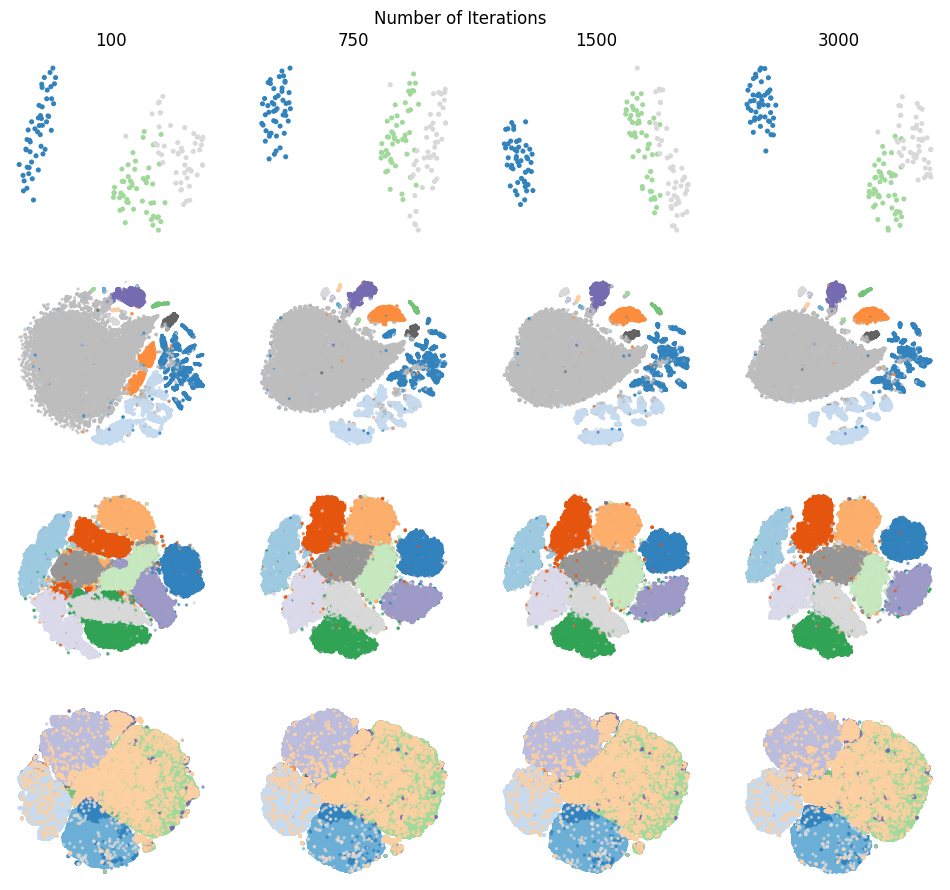

In [203]:
plot_embedding_grid(embedding_dict, row_parameter=[0,1,2,3], column_parameter=iteration_lengths, row_string="", column_string="Number of Iterations", cmap="tab20b")

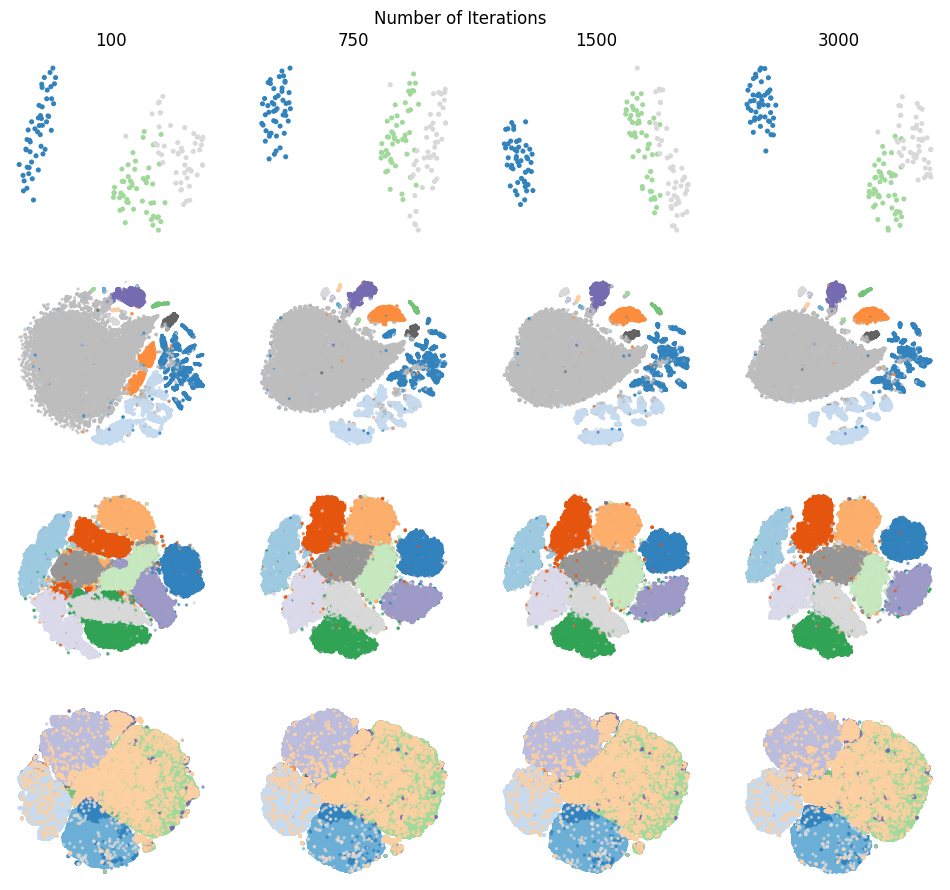

In [210]:
plot_embedding_grid(embedding_dict, row_parameter=[0,1,2,3], column_parameter=iteration_lengths, row_string="", column_string="Number of Iterations", cmap="tab20c")

In [120]:
quality_results = compute_quality_results(embedding_dict, all_data)

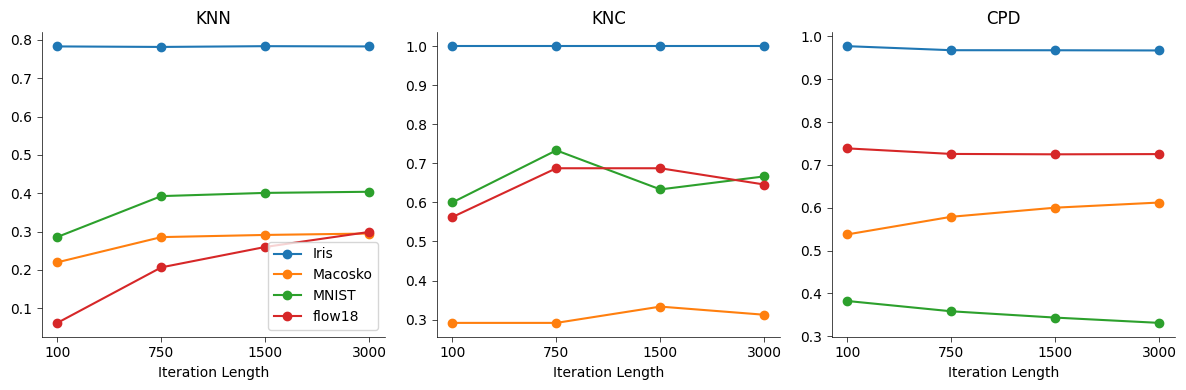

In [207]:
plot_quality_measures(quality_results)

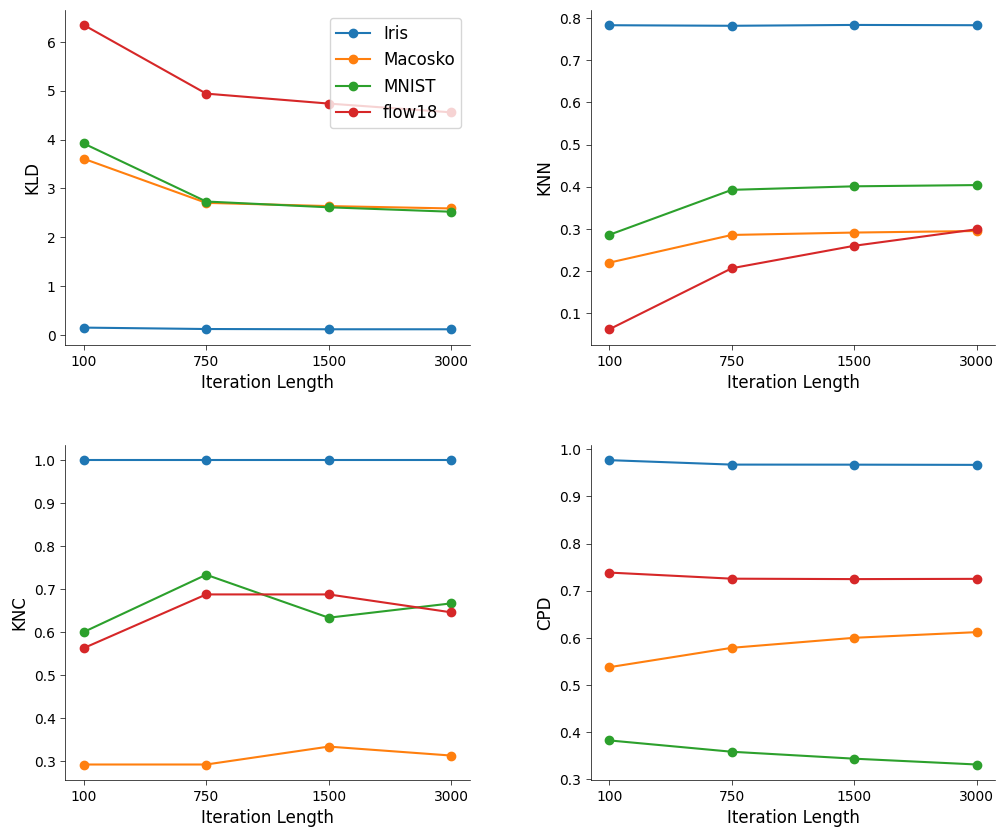

In [196]:
plot_quality_measures_incl_kld(quality_results, embedding_dict)